# Cahn-Hilliard Equation 

Here we solve the [Cahn-Hilliard equation](https://en.wikipedia.org/wiki/Cahn%E2%80%93Hilliard_equation)
\begin{align*}
    0 &= D \Delta \left(u^3-u-\gamma \Delta u\right) - \partial_t u\\
    &= D \left(3 u^2 \Delta u - \Delta u - \gamma \Delta^2 u\right) - \partial_t u\\
    &= D\left(3u^2-1\right) \Delta u - \left(D \gamma \Delta^2 u + \partial_t u\right)
\end{align*}
where $\Delta$ is the Laplacian, $D$ is a diffusiion coefficient, and $\sqrt{\gamma}$ is the length of the transition regions between domains.

Define the linear functionals
$$t_1 := u,\qquad t_2 := D\Delta u, \qquad t_3 := D \gamma \Delta^2 u + \partial_t u$$
so the PDE reads 
$$0=\left(3t_1^2-1\right) t_2 - t_3$$

In [1]:
import qmcpy as qp 
import numpy as np 
import torch
import time
from collections import OrderedDict
import scipy.fftpack
import h5py

In [2]:
from matplotlib import pyplot,cm,colors,gridspec
pyplot.style.use('seaborn-whitegrid')
LW = 3 # linewidth

## PDE Setup

In [3]:
D = 1e-8
GAMMA = 1/2
ns = torch.tensor([ # number of collocation points
    2**9, # on the interior
    2**7, # boundary initial condition
],dtype=int)
us = torch.tensor([ # dimensions not projected to the 0 boundary
    [True,True,True], # interior points (not projected to the 0 boundary)
    [False,True,True], # boundary points initial condition
],dtype=bool) 
llbetas = [ # derivative orders 
    [ # interior
        torch.tensor([[0,0,0]],dtype=int), # u
        torch.tensor([[0,2,0],[0,0,2]],dtype=int), # laplacian u
        torch.tensor([[0,4,0],[0,2,2],[0,0,4],[1,0,0]],dtype=int), # laplacian^2 u 
    ],
    [ # boundary initial condition
        torch.tensor([[0,0,0]],dtype=int) # u
    ],
]
llcs = [ # summand of derivatives coefficients
    [ # interior
        torch.ones(1,dtype=float), # u 
        torch.tensor([D,D],dtype=float), # D*laplacian(u)
        torch.tensor([D*GAMMA,D*GAMMA,D*GAMMA,1],dtype=float) # D*GAMMA*laplacian^2(u)+du/dt 
    ],
    [ # boundary initial condition
        torch.ones(1,dtype=float), # u
    ],
]

## Reference Solver

In [19]:
dt = 0.1#0.000001
maxiter = 5#2001
M,N = 16,16#128,128
xright,yright = 1,1
t = np.linspace(0, dt * maxiter + dt, maxiter)
x = np.linspace(0.5 * xright / M, xright - 0.5 * xright / M, M)
y = np.linspace(0.5 * yright / N, yright - 0.5 * yright / N, N)
tmesh,xmesh,ymesh = np.meshgrid(t,x,y,indexing="ij")
ticks = np.vstack([tmesh.flatten(),xmesh.flatten(),ymesh.flatten()]).T
print("ticks.shape = %s"%str(tuple(ticks.shape)))
xmesh0,ymesh0 = np.meshgrid(x,y) 
ticks0 = np.vstack([np.ones(M*N),xmesh0.flatten(),ymesh0.flatten()]).T
print("ticks0.shape = %s"%str(tuple(ticks0.shape)))
print("log2(len(ticks)) = %.1f"%np.log2(len(ticks)))

ticks.shape = (1280, 3)
ticks0.shape = (256, 3)
log2(len(ticks)) = 10.3


In [20]:
rng = np.random.Generator(np.random.SFC64(seed=None))
u0_ic = 2*rng.integers(low=0,high=2,size=M*N)-1 # independent uniforms over {-1,1}
print("u0_ic.shape = %s with unique values %s"%(u0_ic.shape,np.unique(u0_ic)))

u0_ic.shape = (256,) with unique values [-1  1]


In [21]:
def dct2(a):

    return scipy.fftpack.dct(scipy.fftpack.dct(a, axis = 0, norm = 'ortho'), axis = 1, norm = 'ortho' )

def idct2(a):

    return scipy.fftpack.idct(scipy.fftpack.idct(a, axis = 0 , norm = 'ortho'), axis = 1 , norm = 'ortho')

def f(a):

    return a ** 3 - 3 * a

def full_update(Uold, M, N, dt, Leig, CHeig):

    fU = f(Uold)
    hat_U = dct2(np.real(Uold.reshape(M, N))).reshape((M * N,))
    Df = dct2(np.real(fU.reshape(M, N)) ).reshape((M * N,)) # The alternative is to build the corresponding (N*M,N*M) 2d DCT matrix via kronecker products
    hat_U = (hat_U + dt * Leig * Df) / CHeig
    Unew = idct2(hat_U.reshape((M, N))).reshape((M * N,))

    return Unew

def solver(U_init):
    epsilon = 0.005
    xp = np.linspace(0, (M - 1) / xright, M)
    yq = np.linspace(0, (N - 1) / yright, N)
    Leig = -(np.tile((xp ** 2), (N, 1)).T + np.tile(yq ** 2,(M, 1))) * (np.pi ** 2)     #(M,N)
    CHeig = np.ones((M, N)) - 2 * dt * Leig + dt * (epsilon ** 2) * (Leig ** 2)

    #Reshaping into vectors
    Leig = Leig.reshape((M * N,))
    CHeig = CHeig.reshape((M * N,))

    U = np.zeros([maxiter, M * N])
    U[0, :] = U_init

    for ii in range(maxiter - 1):
        U[ii + 1, :] = full_update(U[ii, :], M, N, dt, Leig, CHeig)

    return U

u_ref = solver(u0_ic).reshape(maxiter,M,N)
print("u_ref.shape: %s"%str(u_ref.shape))

u_ref.shape: (5, 16, 16)


In [22]:
def pde_lhs(lt_i, lt_ic):
    t1_i,t2_i,t3_i = lt_i
    t1_ic = lt_ic[0]
    lhs_i = (3*t1_i**2-1)*t2_i-t3_i
    lhs_ic = t1_ic
    return lhs_i,lhs_ic
def pde_rhs(x_i, x_ic):
    y_i = torch.zeros(len(x_i),dtype=float)
    y_ic = torch.from_numpy(u0_ic)
    return y_i,y_ic

## Kernel Interpolant 

### Construction

In [ ]:
noise = 1e-8
kernel = qp.KernelGaussian(dimension=3,lengthscales=1e-2,scale=1.,torchify=True) # kernel
xs,ns,us = [torch.from_numpy(ticks),torch.from_numpy(ticks0)],None,None
ki = qp.PDEGramMatrix(kernel,xs,ns,us,llbetas,llcs,noise,half_comp=[True,False]) # kernel interpolant

### PDE Optimization

In [24]:
z,data = ki.pde_opt_gauss_newton(
    pde_lhs = pde_lhs,
    pde_rhs = pde_rhs,
    maxiter = 8,
    verbose = True)

    iter (8 max)   loss           
    0              4.08e-01       
    1              6.17e-14       
    2              6.17e-14       
    3              6.17e-14       
    4              6.17e-14       
    5              6.17e-14       
    6              6.17e-14       
    7              6.17e-14       
    8              6.17e-14       


### Fitting

In [25]:
coeffs = ki._solve(z) 
kvec = ki.get_new_left_full_gram_matrix(torch.from_numpy(ticks))
approxmesh = (kvec@coeffs).reshape(tmesh.shape)
print("ymesh.shape = %s"%str(tuple(ymesh.shape)))

ymesh.shape = (5, 16, 16)


In [27]:
approxmesh.min(),approxmesh.max()

(tensor(-1.3732e-07, dtype=torch.float64),
 tensor(1.3722e-07, dtype=torch.float64))

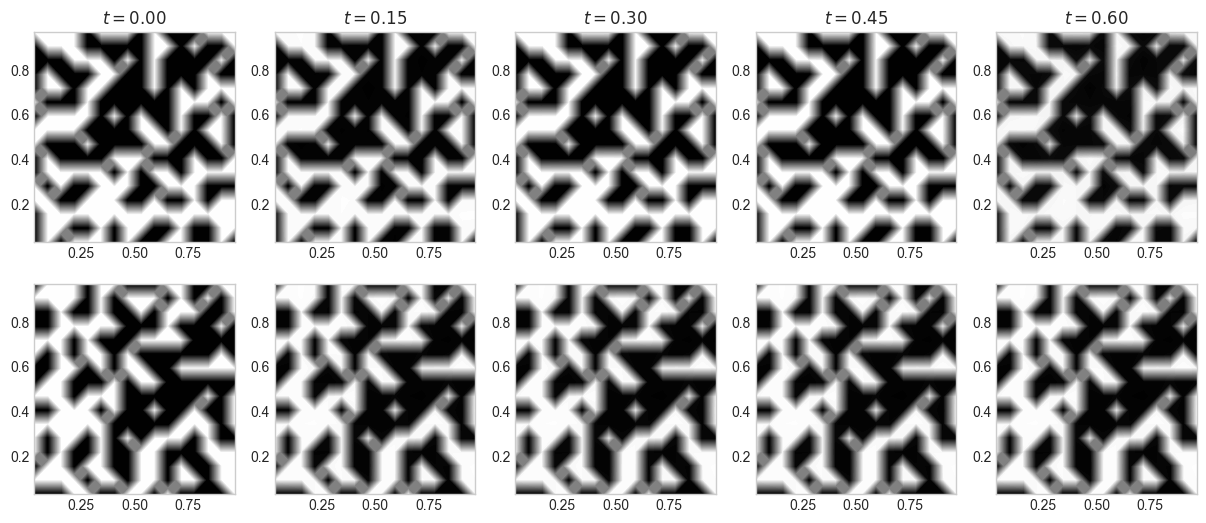

In [26]:
maxrows = fig,ax = pyplot.subplots(nrows=2,ncols=len(t),figsize=(3*len(t),3*2))
#ymin,ymax = ymesh.min(),ymesh.max()
for i in range(len(t)):
    ax[0,i].set_title("$t = %.2f$"%t[i])
    ax[0,i].contourf(xmesh[i],ymesh[i],approxmesh[i],antialiased=False,cmap=cm.binary, levels=100)#, vmin=ymin, vmax=ymax)
    ax[1,i].contourf(xmesh[i],ymesh[i],u_ref[i],antialiased=False,cmap=cm.binary, levels=100)
    #ax[1,i].scatter(ticks0[:,1],ticks0[:,2],color=cm.binary(u_ref[i].flatten()))
    # ax[1,0].scatter(ki.xs[1][flag_u0_1,1],ki.xs[1][flag_u0_1,2],color="k",s=50)
    # ax[1,0].scatter(ki.xs[1][~flag_u0_1,1],ki.xs[1][~flag_u0_1,2],color="w",s=50);